In [11]:
# Standard library imports
import copy
from datetime import datetime
import os
from pathlib import Path
import gzip
import pickle

from collections import Counter

import io
import base64
import json

# Related third party imports
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imageio
import numpy as np
import open3d as o3d
import torch
import torch.nn.functional as F
from tqdm import tqdm, trange

import openai
from openai import OpenAI

from conceptgraph.dataset.datasets_common import get_dataset

from conceptgraph.slam.slam_classes import MapObjectList, DetectionList
from conceptgraph.scripts.visualize_cfslam_results import load_result

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
replica_root = "/rvl-home/guqiao/rdata/Replica/"
scene_name = "room0"

dataset_config_path = "/rvl-home/guqiao/src/concept-graphs/conceptgraph/dataset/dataconfigs/replica/replica.yaml"

dataset = get_dataset(
    dataconfig = dataset_config_path, 
    stride=5,
    basedir=replica_root,
    sequence=scene_name,
    device="cpu",
    dtype=torch.float,
)

def get_det_result(color_path, detection_folder_name="gsa_detections_ram_withbg_allclasses"):
    color_path = Path(color_path)
    detections_path = color_path.parent.parent / detection_folder_name / color_path.name
    detections_path = detections_path.with_suffix(".pkl.gz")
    color_path = str(color_path)
    detections_path = str(detections_path)
    
    with gzip.open(detections_path, "rb") as f:
        gobs = pickle.load(f)
    return gobs

Done! Execution time of get_dataset function: 0.08 seconds


In [3]:
result_path = "/rvl-home/guqiao/rdata/Replica/room0/pcd_saves/full_pcd_ram_withbg_allclasses_overlap_maskconf0.25_simsum1.2_dbscan.1_masksub_20230814_164846_post.pkl.gz"

objects, bg_objects, class_colors = load_result(result_path)

print(f"Loaded {len(objects)} objects and {len(bg_objects)} bg objects")

Loaded 58 objects and 3 bg objects


In [ ]:
for oid, obj in enumerate(objects):
    print(f"Object {oid}: {Counter(obj['class_name'])}")

    for det_id in range(len(obj['image_idx'])):
        image_id = obj['image_idx'][det_id]
        mask_id = obj['mask_idx'][det_id]
        
        print(f"Image {image_id}, mask {mask_id}")
        color, _, _, _ = dataset[image_id]
        color = color.detach().cpu().numpy()
        color = color.round().astype(np.uint8)

        # Load the mask from the original detection file        
        # color_path = dataset.color_paths[image_id]
        # gobs = get_det_result(color_path)
        # mask = gobs['mask'][mask_id]
        
        # Use the cached masks in objects
        mask = obj['mask'][det_id]

        mask = mask.astype(float)
        mask = cv2.resize(mask, (color.shape[1], color.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0.5)
        
        plt.imshow(color)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
        break
    
    break

In [6]:
for oid, obj in enumerate(objects):
    print(f"Object {oid}: {Counter(obj['class_name'])}")
    
    n_points = len(obj['pcd'].points)
    pcd_points = np.asarray(obj['pcd'].points)
    pcd_center = pcd_points.mean(axis=0)
    pcd_extent = pcd_points.max(axis=0) - pcd_points.min(axis=0)
    
    vis_points = np.asarray(obj['n_points'])
    vis_ratio = vis_points / n_points
    
    image_idx = np.asarray(obj['image_idx'])
    
    vis_ratio_all = np.zeros(len(dataset))
    vis_ratio_all[image_idx] = vis_ratio
    
    print(f"Number of points: {n_points}")
    print(f"Center: {pcd_center}")
    print(f"Extent: {pcd_extent}")
    print(f"vis_ratio_all: {vis_ratio_all.max()}, {vis_ratio_all.min()}")
    
    break

Object 0: Counter({'lamp': 141})
Number of points: 604
Center: [ 2.27491015 -0.71740223 -0.26755056]
Extent: [0.42613317 0.42136103 0.27117018]
vis_ratio_all: 1.216887417218543, 0.0


i = 42
j = 40


/rvl-home/guqiao/anaconda3/envs/conceptgraph/lib/python3.10/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


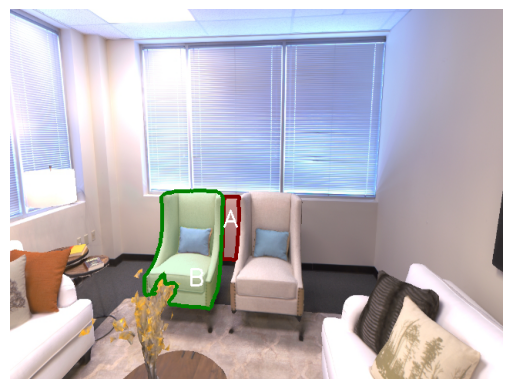

{
    "type": "0",
    "relationship": "No relationship",
    "reason": "Object A, which is a red pillow, and Object B, which is a green armchair, are not in a supporting relationship. The pillow (A) is placed on a different chair adjacent to the armchair (B) and is not supported by or supporting the armchair."
}


In [16]:
def compute_norm_dist(obj_a, obj_b):
    '''
    Compute the distance between two objects, normalized by their extents
    '''
    points_a = np.asarray(obj_a['pcd'].points)
    center_a = points_a.mean(axis=0)
    extent_a = points_a.max(axis=0) - points_a.min(axis=0)
    
    points_b = np.asarray(obj_b['pcd'].points)
    center_b = points_b.mean(axis=0)
    extent_b = points_b.max(axis=0) - points_b.min(axis=0)
    
    dist = np.absolute(center_a - center_b)
    norm_dist = dist / ((extent_a + extent_b) / 2.0)
    
    return norm_dist
    
def compute_mutual_vis_ratio(obj_a, obj_b):
    '''
    Compute the product the visibility ratio of a pair of objects. 
    
    Visibility ratio is the ratio between the number of points visible in one view 
    and that of the fully built 3D object. 
    
    In order for GPT to reason about the relationship between two objects, we want 
    to get some images where both objects are mostly visible. So we compute this ratio
    and use it to select relevant images. 
    '''
    n_images = max(
        np.asarray(obj_a['image_idx']).max(),
        np.asarray(obj_b['image_idx']).max()
    ) + 1
    
    n_points_a = len(obj_a['pcd'].points)
    n_points_b = len(obj_b['pcd'].points)
    
    vis_ratio_a = np.zeros(n_images)
    vis_ratio_b = np.zeros(n_images)

    image_idx_a = np.asarray(obj_a['image_idx'])
    image_idx_b = np.asarray(obj_b['image_idx'])
    
    vis_points_a = np.asarray(obj_a['n_points'])
    vis_points_b = np.asarray(obj_b['n_points'])
    
    vis_ratio_a[image_idx_a] = vis_points_a / n_points_a
    vis_ratio_b[image_idx_b] = vis_points_b / n_points_b
    
    mutual_vis_ratio = vis_ratio_a * vis_ratio_b
    
    return mutual_vis_ratio, vis_ratio_a, vis_ratio_b

def resize_mask(mask, h, w):
    mask = mask.astype(float)
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0.5)
    return mask

def draw_mask_on_image(mask, image, color, contour_width=3):
    '''
    Draw the mask on image. The contour of the mask is first computed and draw on the 
    image in dark color (e.g. dark red). Then the inner region of the mask is draw on 
    image in light color (e.g. light red). The original content of the image in the
    masked region will still be visible
    
    mask: numpy.ndarray of shape (H, W), dtype bool
    image: numpy.ndarray of shape (H, W, 3), dtype uint8
    '''
    # Copy the image to avoid altering the original
    output_image = image.copy()

    # Create darker and lighter shades of the provided color
    darker_color = tuple([x // 2 for x in color])  # Darken by reducing brightness by half
    lighter_color = tuple([min(x + 100, 255) for x in color])  # Lighten by increasing brightness
    
    # Create a colored version of the mask
    colored_mask = image # preserve the original image in the blending process
    colored_mask[mask] = lighter_color
    
    # Draw the filled mask with the lighter color, use a blend to keep underlying details
    cv2.addWeighted(output_image, 0.8, colored_mask, 0.2, 0, output_image)

    # Find contours of the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours with the darker color
    cv2.drawContours(output_image, contours, -1, darker_color, contour_width)

    return output_image


def draw_number_in_mask(image, binary_mask, text, color, font_scale = 1, thickness = 2):
    """
    Find proper places to draw text given a binary mask, and then draw the text on the image
    """
    binary_mask = binary_mask.astype(np.uint8)
    binary_mask = np.pad(binary_mask, ((1, 1), (1, 1)), 'constant')
    mask_dt = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 0)
    mask_dt = mask_dt[1:-1, 1:-1]
    max_dist = np.max(mask_dt)
    coords_y, coords_x = np.where(mask_dt == max_dist)  # coords is [y, x]
     
    x = coords_x[len(coords_x)//2]
    y = coords_y[len(coords_y)//2]
    
    # Determine font for the text.
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Calculate the size of the text to adjust the coordinates.
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]

    # Modify x, y coordinates to center the text by adjusting with the text size.
    x -= text_size[0] // 2  # Center horizontally
    y += text_size[1] // 2  # Center vertically

    # Draw the text at the chosen position with given color and font settings.
    cv2.putText(image, text, (x, y), font, font_scale, color, thickness)

    return image


def crop_image_with_padding(image, mask, padding):
    """
    Crops an image using a boolean mask with added padding.

    Parameters:
        image (np.array): The input image as a numpy array of shape (H, W, 3).
        mask (np.array): A boolean mask of shape (H, W) where True indicates the pixels to keep.
        padding (int): The number of pixels to add as padding around the crop.

    Returns:
        np.array: The cropped and padded image.
    """
    if image.shape[:2] != mask.shape:
        raise ValueError("The dimensions of the image and the mask must match")
    
    # Finding the bounding box from the mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Adding padding to the coordinates
    rmin = max(rmin - padding, 0)
    rmax = min(rmax + padding, image.shape[0])
    cmin = max(cmin - padding, 0)
    cmax = min(cmax + padding, image.shape[1])

    # Cropping the image
    cropped_image = image[rmin:rmax+1, cmin:cmax+1]

    return cropped_image

def encode_numpy_image_to_base64(np_image: np.ndarray) -> str:
    """
    Encodes a numpy array (HxWx3, dtype uint8) representing an image into a base64 string.
    
    Args:
    np_image (np.ndarray): A HxWx3 numpy array with dtype uint8, representing an RGB image.

    Returns:
    str: The base64 encoded string of the image.
    """
    # Check if input is a valid HxWx3 numpy array of dtype uint8
    if not (isinstance(np_image, np.ndarray) and np_image.ndim == 3 and np_image.shape[2] == 3 and np_image.dtype == np.uint8):
        raise ValueError("Input must be a HxWx3 numpy array with dtype uint8.")
    
    # Convert numpy array to PIL Image
    image = Image.fromarray(np_image)
    
    # Save the PIL Image to a bytes buffer
    img_buffer = io.BytesIO()
    image.save(img_buffer, format='JPEG')  # Can use PNG or other formats depending on the requirement
    
    # Get bytes data from the buffer and encode it in base64
    byte_data = img_buffer.getvalue()
    base64_str = base64.b64encode(byte_data).decode('utf-8')
    
    return base64_str

client = openai.OpenAI(
  api_key=os.getenv('OPENAI_API_KEY')
)

system_prompt = '''
    You are an agent specialized in describing the spatial relationships between objects in an annotated image.
    
    You will be provided with an annotated image, where two objects are highlighted. The object highlighted in red is object A and the object highlighted in green is object B respectively. You will analyze the image and decide whether there is a spatial relationship between them. If there is, you will select one relationship from the following list: 
    
    - 0 - No relationship: return this if the pair of objects does not fall in any other relationships. 
    - 1 - A on top of B: Object A is on top of object B. Return this relationship if the object A is physically supported by the object B in the 3D space. Do NOT return this if A is just visually above B in 2D or if A is placed on the top of B but there is no supporting relationship. 
    - 2 - B on top of A: Object B is on top of object A. Return this relationship if the object B is physically supported by the object A in the 3D space. Do NOT return this if B is just visually above A in 2D or if B is placed on the top of A but there is no supporting relationship.
    
    Return the result in JSON in the following format:
    
    {
        "type": "<A number index of the relationship, e.g. 0>",
        "relationship": "<Relationship in text, e.g. A on top of B>",
        "reason": "<Explain briefly what object A and B are and your reasoning about the spatial relationship between A and B>",
    }
'''

def parse_relation(image: np.ndarray):
    base64_image = encode_numpy_image_to_base64(image)
    
    response = client.chat.completions.create(
        model="gpt-4-turbo-2024-04-09",
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Return the spatial relationships between the highlighted objects in the image."
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            },
        ],
        max_tokens=512,
        top_p=0.1
    )

    return response.choices[0].message.content

n_objects = len(objects)

# for i in range(1, n_objects):
#     for j in range(i+1, n_objects):
for _ in range(20):
    for __ in range(20):
        i, j = np.random.choice(n_objects, 2, replace=False)
        
        obj_a = objects[i]
        obj_b = objects[j]
        
        # filter object pairs by their geometric distance
        norm_dist = compute_norm_dist(obj_a, obj_b)
        
        if norm_dist.max() > 1.5:
            # Skip this pair as they are too far away
            continue
        
        # print(f"Object a {i}: {Counter(obj_a['class_name'])}")
        # print(f"Object b {j}: {Counter(obj_b['class_name'])}")
        # print(f"Norm dist: {norm_dist}")
        
        # Get the image with maximum mutual visiblity ratio
        mutual_vis_ratio, vis_ratio_a, vis_ratio_b = compute_mutual_vis_ratio(obj_a, obj_b)
        image_id, max_mutual_vis_ratio = mutual_vis_ratio.argmax(), mutual_vis_ratio.max()
        
        if max_mutual_vis_ratio < 0.1:
            # Skip if they are not co-visible at any image
            continue
        
        print(f"i = {i}")
        print(f"j = {j}")
        
        # print(image_id, max_mutual_vis_ratio)
        color, _, _, _ = dataset[image_id]
        color = color.detach().cpu().numpy()
        color = color.round().astype(np.uint8)
        
        det_id_a = np.where(np.asarray(obj_a['image_idx']) == image_id)[0][0]
        mask_a = obj_a['mask'][det_id_a]
        mask_a = resize_mask(mask_a, color.shape[0], color.shape[1])
        
        det_id_b = np.where(np.asarray(obj_b['image_idx']) == image_id)[0][0]
        mask_b = obj_b['mask'][det_id_b]
        mask_b = resize_mask(mask_b, color.shape[0], color.shape[1])
        
        # plt.imshow(color); plt.show()
        # plt.imshow(mask_a); plt.show()
        # plt.imshow(mask_b); plt.show()
        
        blend_image = draw_mask_on_image(mask_a, color, (255, 0, 0), contour_width=3)
        blend_image = draw_mask_on_image(mask_b, blend_image, (0, 255, 0), contour_width=3)
        
        blend_image = draw_number_in_mask(blend_image, mask_a, "A", (255, 255, 255), font_scale=1, thickness=2)
        blend_image = draw_number_in_mask(blend_image, mask_b, "B", (255, 255, 255), font_scale=1, thickness=2)
        
        # mask_union = np.logical_or(mask_a, mask_b)
        # blend_image = crop_image_with_padding(blend_image, mask_union, padding=50)
        
        plt.imshow(blend_image)
        plt.axis("off")
        plt.show()
        
        relation_res = parse_relation(blend_image)
        print(relation_res)
        
        relation = json.loads(relation_res)
        
        break
    break

In [17]:
relation

{'type': '0',
 'relationship': 'No relationship',
 'reason': 'Object A, which is a red pillow, and Object B, which is a green armchair, are not in a supporting relationship. The pillow (A) is placed on a different chair adjacent to the armchair (B) and is not supported by or supporting the armchair.'}